# Causal Analysis of Synthetic Dataset

In [50]:
import networkx as nx
import numpy as np
import pandas as pd
import dowhy
import dowhy.plotter as plotter
from dowhy.do_why import CausalModel
import random

random.seed(0)
np.random.seed(0)

#TREATMENT = 'ContinentOfBirth'
TREATMENT = 'CitizenshipContinent'

In [51]:
dataset = pd.read_csv('data/synthetic-dataset-scenario-B.csv')

In [52]:
# Introduce binary treatment column as proposed by Data X-Ray
dataset['Treatment'] = dataset[TREATMENT] == 'Asia'
dataset.head()

,Source,Last Name,CountryOfBirth,ContinentOfBirth,CitizenshipCountry,CitizenshipContinent,NumChildren,MaritalStatus,Last Name Correct,Treatment
0,B,ztyji,China,Asia,China,Asia,2,Married,False,True
1,B,eqjin,Canada,North America,Canada,North America,2,Single,True,False
2,D,npqyp,China,Asia,China,Asia,4,Widowed,False,True
3,A,vwsqy,France,Europe,Canada,North America,4,Widowed,True,False
4,A,jsnjz,Japan,Asia,Japan,Asia,2,Single,True,True


In [53]:
graph = nx.DiGraph()

# potential confounders
for col in dataset.drop(['Last Name', 'Last Name Correct', 'Treatment', TREATMENT, 'CitizenshipCountry'], axis=1).columns:
    graph.add_edge(col, 'Treatment')
    graph.add_edge(col, 'Last Name Correct')
    
#graph.add_edge('Unobserved Confounders', 'Treatment')
#graph.add_edge('Unobserved Confounders', 'Last Name Correct')

# Assumed causal relation
graph.add_edge('Treatment', 'Last Name Correct')

['NumChildren', 'Source', 'CountryOfBirth', 'ContinentOfBirth', 'MaritalStatus']
yes
{'observed': 'yes'}
yes
{'observed': 'yes'}
yes
{'observed': 'yes'}
yes
{'observed': 'yes'}
yes
{'observed': 'yes'}
Model to find the causal effect of treatment Treatment on outcome Last Name Correct
Using Matplotlib for plotting


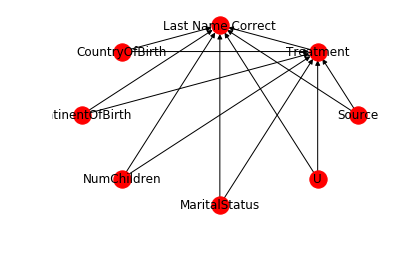

In [54]:
model = CausalModel(data = dataset, treatment='Treatment', outcome='Last Name Correct', graph=''.join(nx.generate_gml(graph)))
model.view_model()

In [55]:
identified_estimand = model.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:{'NumChildren', 'U', 'Source', 'CountryOfBirth', 'ContinentOfBirth', 'MaritalStatus'}


{'observed': 'yes'}
{'label': 'Unobserved Confounders', 'observed': 'no'}
There are unobserved common causes. Causal effect cannot be identified.


WARN: Do you want to continue by ignoring these unobserved confounders? [y/n]  y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                                                                         
──────────(Expectation(Last Name Correct|NumChildren,Source,CountryOfBirth,Con
dTreatment                                                                    

                             
tinentOfBirth,MaritalStatus))
                             
Estimand assumption 1, Unconfoundedness: If U→Treatment and U→Last Name Correct then P(Last Name Correct|Treatment,NumChildren,Source,CountryOfBirth,ContinentOfBirth,MaritalStatus,U) = P(Last Name Correct|Treatment,NumChildren,Source,CountryOfBirth,ContinentOfBirth,MaritalStatus)
### Estimand : 2
Estimand name: iv
No such variable found!



In [56]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name='backdoor.linear_regression')
print(causal_estimate)
print('Causal Estimate is ' + str(causal_estimate.value))

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Last Name Correct~Treatment+NumChildren+Source+CountryOfBirth+ContinentOfBirth+MaritalStatus


LinearRegressionEstimator
*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                                                                         
──────────(Expectation(Last Name Correct|NumChildren,Source,CountryOfBirth,Con
dTreatment                                                                    

                             
tinentOfBirth,MaritalStatus))
                             
Estimand assumption 1, Unconfoundedness: If U→Treatment and U→Last Name Correct then P(Last Name Correct|Treatment,NumChildren,Source,CountryOfBirth,ContinentOfBirth,MaritalStatus,U) = P(Last Name Correct|Treatment,NumChildren,Source,CountryOfBirth,ContinentOfBirth,MaritalStatus)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: Last Name Correct~Treatment+NumChildren+Source+CountryOfBirth+ContinentOfBirth+MaritalStatus
## Estimate
Value: 0.006974699875555585

Causal Estimate is 0.0

In [57]:
res_random = model.refute_estimate(identified_estimand, causal_estimate, method_name='random_common_cause')
print(res_random)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Last Name Correct~Treatment+NumChildren+Source+CountryOfBirth+ContinentOfBirth+MaritalStatus+w_random


Refute: Add a Random Common Cause
Estimated effect:(0.006974699875555585,)
New effect:(0.01499086096533532,)



In [58]:
res_placebo = model.refute_estimate(identified_estimand, causal_estimate, method_name='placebo_treatment_refuter', placebo_type='permute')
print(res_placebo)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Last Name Correct~placebo+NumChildren+Source+CountryOfBirth+ContinentOfBirth+MaritalStatus


Refute: Use a Placebo Treatment
Estimated effect:(0.006974699875555585,)
New effect:(-0.0018912163960725648,)



In [59]:
res_subset = model.refute_estimate(identified_estimand, causal_estimate, method_name='data_subset_refuter', subset_fraction=0.9)
print(res_subset)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Last Name Correct~Treatment+NumChildren+Source+CountryOfBirth+ContinentOfBirth+MaritalStatus


Refute: Use a subset of data
Estimated effect:(0.006974699875555585,)
New effect:(0.009460534184167032,)

